In [1]:
# Standard library imports
import json 

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm.auto import tqdm

/Users/leo/Programming/steel/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Exploration and Preprocessing

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [4]:
df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


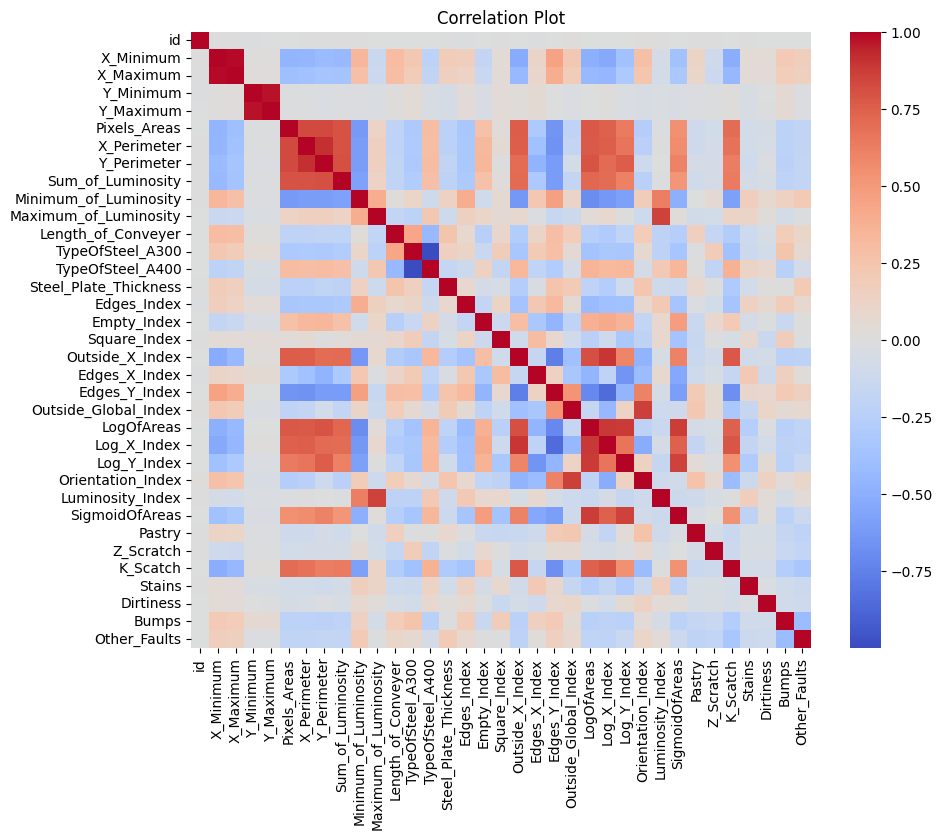

In [5]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()

### Feature Engineering

In [6]:
df["X_Diff"] = df["X_Maximum"] - df["X_Minimum"]
df["Y_Diff"] = df["Y_Maximum"] - df["Y_Minimum"]
df["Lum_Diff"] = df["Maximum_of_Luminosity"] - df["Minimum_of_Luminosity"]

### Feature Importance

In [7]:
# Separate features and targets
X = df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'id'], axis=1)
y = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X_train.columns.tolist()

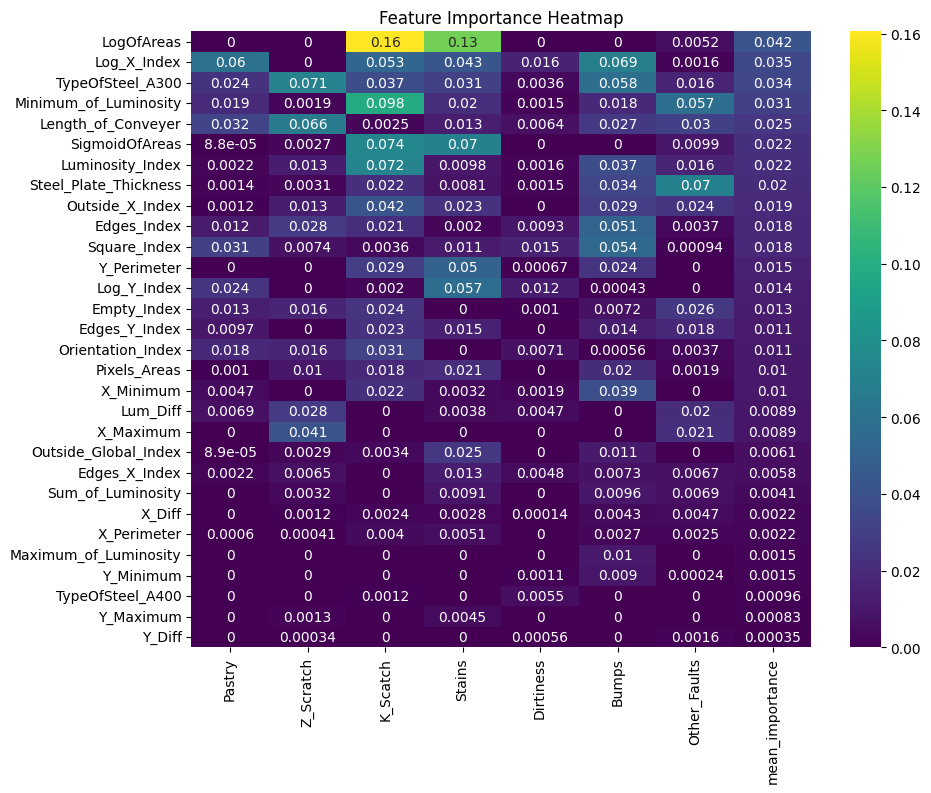

In [8]:
# It's a good practice to scale your features before applying Lasso, 
# as it is sensitive to the scale of input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Example adjustment for multiple binary targets
feature_importances = {}  # Dictionary to hold feature importance for each target

for target in y_train.columns:
    y = y_train[target]
    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train_scaled, y)
    feature_importances[target] = abs(lasso.coef_)

# Convert the dictionary to a DataFrame for easier visualization
importance_df = pd.DataFrame(feature_importances, index=feature_names)
importance_df['mean_importance'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values(by='mean_importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.heatmap(importance_df, annot=True, cmap='viridis')
plt.title('Feature Importance Heatmap')
plt.show()


In [9]:
def remove_unnecessary_targets(df, target_to_keep):
    # Define the columns to potentially drop (exclude the target column to keep)
    cols_to_drop = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'id']
    
    # Ensure the target column to keep is not in the cols_to_drop list
    if target_to_keep in cols_to_drop:
        cols_to_drop.remove(target_to_keep)
    
    # Use the drop method to remove the unnecessary columns
    # Ensure to specify axis=1 to indicate these are columns
    cleaned_df = df.drop(columns=cols_to_drop)
    
    return cleaned_df

def determine_important_features(df, target, alpha=0.001, top_n=5):
    # Separate features and target
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit a Lasso model to the data
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)

    # Extract the feature importances (absolute values of coefficients)
    feature_importances = np.abs(lasso.coef_)

    # Sort features by their importance and select top_n
    top_n_indices = np.argsort(feature_importances)[-top_n:]
    important_features = X.columns[top_n_indices].tolist()

    return important_features

def create_relevant_feature_df(df, target, alpha=0.001, top_n=5):
    # Determine the important features
    important_features = determine_important_features(df, target, alpha, top_n)
    
    # Include the target in the list of columns to select
    columns_to_select = important_features + [target]
    
    # Create a DataFrame with only the relevant features and the target
    relevant_feature_df = df[columns_to_select]
    
    return relevant_feature_df

def optimize_model_with_gridsearch(df, target, model, param_grid, test_size=0.2, random_state=42, scoring='roc_auc'):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=2, verbose=1, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Assuming the positive class is at index 1
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Best score (CV AUC): {best_score}")
    print(f"Test AUC: {test_auc}")
    
    return best_model, best_score

# Define your model and parameter grid for XGBoost
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [100, 250, 500, 750],
    'max_depth': [6, 10, 15, 25],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 5, 10, 15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

best_hyperparams_and_scores_for_targets = {}

for target in tqdm(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], desc='Targets'):
    best_hyperparams_and_scores_for_top_n = {}
    cleaned_df = remove_unnecessary_targets(df, target)
    for top_n in range(18, 28, 2):
        relevant_feature_df = create_relevant_feature_df(cleaned_df, target, top_n=top_n)
        important_features = determine_important_features(cleaned_df, target, alpha=0.001, top_n=top_n)
        best_model, best_score = optimize_model_with_gridsearch(relevant_feature_df, target, model, param_grid)
        best_hyperparams_and_scores_for_top_n[top_n] = {
            'best_score': best_score,
            'best_hyperparameters': best_model.get_params(),
            'important_features': important_features
        }
    best_hyperparams_and_scores_for_targets[target] = best_hyperparams_and_scores_for_top_n

# Specify the file path
file_path = "/Users/leo/Programming/steel/models/RF/opt_params_xgb.json"

# Write the best_hyperparams_and_scores_for_targets dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(best_hyperparams_and_scores_for_targets, json_file, indent=4)

print("Best scores and hyperparameters for each target and top_n have been saved to", file_path)

Targets:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8647760198422649
Test AUC: 0.8746655939417297
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8641008444470998
Test AUC: 0.8759061665743035
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.86406040984107
Test AUC: 0.8756398607332976
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8641347861045492
Test AUC: 0.8743767833817654
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Targets:  14%|█▍        | 1/7 [29:17<2:55:44, 1757.38s/it]

Best score (CV AUC): 0.8643251421590918
Test AUC: 0.8753660533193053
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9579471601191896
Test AUC: 0.9619594120008027
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9577999649058122
Test AUC: 0.9617587296809151
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9576998946165565
Test AUC: 0.9609560004013645
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9573812680628191
Test AUC: 0.9610701384708007
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Targets:  29%|██▊       | 2/7 [52:59<2:10:01, 1560.35s/it]

Best score (CV AUC): 0.9571393848917404
Test AUC: 0.9623519967890829
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9842066720310977
Test AUC: 0.9866078301531568
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.984179284235576
Test AUC: 0.9867622481780527
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9841666609950657
Test AUC: 0.9866212779691388
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9840783737670564
Test AUC: 0.9866792426931987
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Targets:  43%|████▎     | 3/7 [1:38:43<2:20:02, 2100.55s/it]

Best score (CV AUC): 0.9841705928608789
Test AUC: 0.9867715225339023
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits
Best score (CV AUC): 0.9921798694517895
Test AUC: 0.9905715811965812
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits
Best score (CV AUC): 0.9924017404434394
Test AUC: 0.9903098290598291
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits
Best score (CV AUC): 0.9922145743176749
Test AUC: 0.9905956196581196
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.9925792298751026
Test AUC: 0.9909107905982906
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


Targets:  57%|█████▋    | 4/7 [1:50:24<1:17:24, 1548.27s/it]

Best score (CV AUC): 0.9927109483782783
Test AUC: 0.990309829059829
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8712813214290098
Test AUC: 0.8831917124391655
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits
Best score (CV AUC): 0.8723530706429607
Test AUC: 0.8823654601505406
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8745187978161434
Test AUC: 0.8880678528394598
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8755465735069705
Test AUC: 0.887604650798867
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Targets:  71%|███████▏  | 5/7 [2:09:29<46:45, 1402.68s/it]  

Best score (CV AUC): 0.878263600149447
Test AUC: 0.8871226702971692
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8109817640133635
Test AUC: 0.8086530390796974
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8101049723849166
Test AUC: 0.8081123421024193
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8097372989198954
Test AUC: 0.8071899004762277
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.8090878129350185
Test AUC: 0.8078954711724501
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Targets:  86%|████████▌ | 6/7 [2:58:59<32:15, 1935.68s/it]

Best score (CV AUC): 0.8090572148840574
Test AUC: 0.8084372784104619
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.7041593255967498
Test AUC: 0.7145258641820336
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.7031126449164096
Test AUC: 0.7149816311644788
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.7027864005909635
Test AUC: 0.714852982466044
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (CV AUC): 0.704009853685891
Test AUC: 0.7150107479599673
Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


/Users/leo/Programming/steel/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Targets: 100%|██████████| 7/7 [4:04:05<00:00, 2092.24s/it]

Best score (CV AUC): 0.7028367242283451
Test AUC: 0.7152670054712835
Best scores and hyperparameters for each target and top_n have been saved to /Users/leo/Programming/steel/models/RF/opt_params_xgb.json


In [10]:
# Load optimized parameters
with open('/Users/leo/Programming/steel/models/RF/opt_params_xgb.json') as f:
    opt_params = json.load(f)

# Load your datasets
train_df = pd.read_csv('/Users/leo/Programming/steel/data/train.csv')  # Make sure the path is correct
test_df = pd.read_csv('/Users/leo/Programming/steel/data/test.csv')  # Make sure the path is correct

# Function to scale features
def scale_features(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def align_features(train_df, test_df, important_features):
    # Add missing columns in test_df with default value of 0
    missing_cols = [f for f in important_features if f not in test_df.columns]
    for col in missing_cols:
        test_df[col] = 0
    # Ensure the order of columns in test_df matches that of important_features
    test_df_aligned = test_df[important_features]
    return test_df_aligned

submission = pd.DataFrame()
submission['id'] = test_df['id']

for target in opt_params.keys():
    print(f"Processing {target}...")
    # Extract the best 'top_n' and its corresponding parameters
    top_n = max(opt_params[target], key=lambda x: opt_params[target][x]['best_score'])
    params = opt_params[target][top_n]['best_hyperparameters']
    print(f"Best top_n: {top_n}")
    print(f"Best hyperparameters: {params}")
    # Determine the important features
    important_features = determine_important_features(train_df, target, top_n=int(top_n))
    print(f"Important features with length {len(important_features)}: {important_features}")
    # Prepare datasets
    X_train = train_df[important_features]
    y_train = train_df[target]
    X_test = align_features(train_df, test_df, important_features)
    
    X_train_scaled = scale_features(X_train)
    X_test_scaled = scale_features(X_test)
    
    # Initialize and train the model
    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train)
    
    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Assuming the positive class is at index 1
    submission[target] = y_pred_proba

# Save submission file
submission_file_path = '/Users/leo/Programming/steel/submission_xgb.csv'
submission.to_csv(submission_file_path, index=False)
print(f"Submission file saved to {submission_file_path}")


Processing Pastry...
Best top_n: 18
Best hyperparameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
Important features w